# Create the reference solar abundance file

Here we join the Asplund+ (2009) data with other sources of information to create our output `solar_abundances.fits` file.

In [2]:
output_file = 'solarabundances.fits'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table,Column,join

## Read in the Asplund+ (2021) data 

In [31]:
fl = 'asplund2021_abundances.csv'
asplund = Table.read(fl)
solar = asplund.copy()

Add column for references:

In [32]:
reference_column = Column(['Asplund+ (2021)']*np.size(solar), name='Reference', dtype='U30')
solar.add_column(reference_column)

## Add mean atomic mass

In [33]:
iso = Table.read('isotopes.dat',format='ascii',comment=';;')
iso.keep_columns(['Z','AtomicWeight'])

Now we need to create dummy masses for total abundances

In [34]:
zzz = np.arange(100,106)

for j in np.arange(len(zzz)):
    iso.add_row([zzz[j],0])

In [35]:
atoms = join(solar,iso,keys='Z')

Now we have all the information we want in the combined table `atoms`.

In [36]:
atoms[0:5]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference,AtomicWeight
int64,str6,float64,float64,float64,float64,float64,float64,str30,float64
1,H,12.0,0.0,8.22,0.04,12.0,0.0,Asplund+ (2021),1.0079
2,He,10.914,0.013,1.29,0.18,10.914,0.013,Asplund+ (2021),4.002602
3,Li,0.96,0.06,3.25,0.04,3.25,0.04,Asplund+ (2021),6.968
4,Be,1.38,0.09,1.32,0.03,1.38,0.09,Asplund+ (2021),9.01218
5,B,2.7,0.2,2.79,0.04,2.7,0.2,Asplund+ (2021),10.813


In [38]:
atoms[-6:].show_in_notebook()

idx,Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference,AtomicWeight
0,100,Xinit,-30.0,-30.0,-30.0,-30.0,0.7121,-30.0,Asplund+ (2021),0.0
1,101,Yinit,-30.0,-30.0,-30.0,-30.0,0.2725,-30.0,Asplund+ (2021),0.0
2,102,Zinit,-30.0,-30.0,-30.0,-30.0,0.0154,-30.0,Asplund+ (2021),0.0
3,103,Xphoto,-30.0,-30.0,-30.0,-30.0,0.7438,-30.0,Asplund+ (2021),0.0
4,104,Yphoto,-30.0,-30.0,-30.0,-30.0,0.2423,-30.0,Asplund+ (2021),0.0
5,105,Zphoto,-30.0,-30.0,-30.0,-30.0,0.0139,-30.0,Asplund+ (2021),0.0


## Write to output file

In [39]:
atoms.write(output_file,overwrite=True)

## Mean metal abundances by mass

In [40]:
# The abundance by mass:
eps = (10.**(atoms['BEST']-12.)*atoms['AtomicWeight']).data
total_mass = eps.sum()

/var/folders/xp/8jbr66bj2b18fmnk_vq23x300000gr/T/ipykernel_83789/3105899659.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(atoms['Z'],np.log10(eps/total_mass),'ro-',markersize=4,lw=1);


Text(0, 0.5, 'logarithmic abundance relative to H')

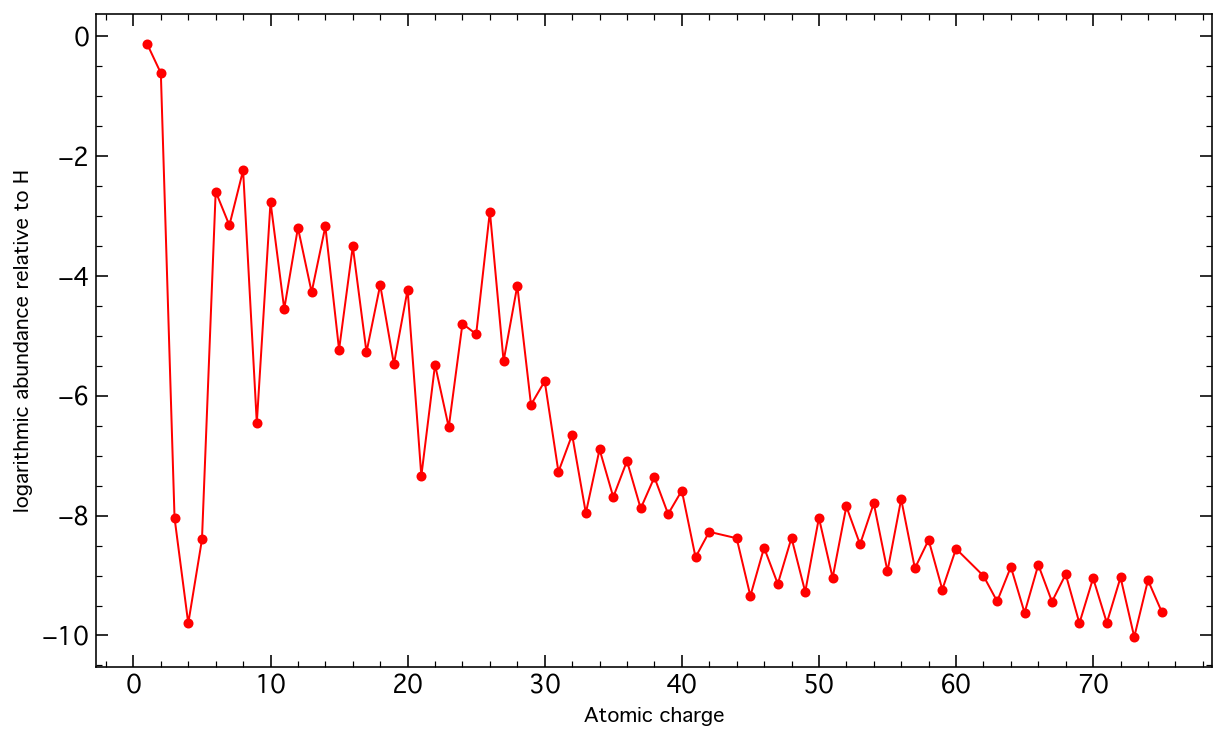

In [45]:
plt.figure(figsize=(10,6))
plt.plot(atoms['Z'],np.log10(eps/total_mass),'ro-',markersize=4,lw=1);
plt.xlabel('Atomic charge')
plt.ylabel('logarithmic abundance relative to H')

## Calculate X, Y, Z

In [46]:
X = eps[0]/total_mass
Y = eps[1]/total_mass

In [47]:
zzz = (atoms['Z'] > 2)
Z = eps[zzz].sum()/total_mass

In [51]:
print("\nCurrent mean abundances by mass: X=H, Y=He, Z=metals; mean mass per H atom, µ.\n")
print("\tX = {0:0.4f}".format(X))
print("\tY = {0:0.4f}".format(Y))
print("\tZ = {0:0.4f}".format(Z))
print("\tµ = 1/X = {0:0.4f}".format(1./X))


Current mean abundances by mass: X=H, Y=He, Z=metals; mean mass per H atom, µ.

	X = 0.7438
	Y = 0.2423
	Z = 0.0139
	µ = 1/X = 1.3445


```

```
# ---- OLD -----

## Read in the Asplund+ (2009) data 
*For convenience, cull to Z < 75.* 

In [52]:
output_file = 'solarabundances_asplund2009.fits'

In [53]:
fl = 'asplund2009_abundances.txt'
asplund = Table.read(fl,format='ascii',comment=';')
asplund.remove_column('DIFF_PH_MET')

#Excise Z>75 data
gd = (asplund['Z'] <= 75)
solar = asplund[gd]

Add column for references:

In [54]:
reference_column = Column(['Asplund+ (2009)']*np.size(solar), name='Reference', dtype='U30')
solar.add_column(reference_column)

Simple text list of element names:

In [55]:
element_names=np.chararray.strip(solar['ELEMENT'])

# Oxygen...issues.

In [56]:
o_indx = np.where((element_names.lower() == 'O'.lower()))
solar[o_indx]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference
int64,str2,float64,float64,float64,float64,float64,float64,str30
8,O,8.69,0.05,8.4,0.04,8.69,0.05,Asplund+ (2009)


## Adopt the Steffen+ (2015) oxygen abundance

In [57]:
steffen = [8.76, 0.02]

solar['BEST'][o_indx] = steffen[0] # Steffen abundance
solar['ERR'][o_indx] = steffen[1]

solar['PHOTO'][o_indx] = steffen[0] # Steffen abundance
solar['PHOTO_ERR'][o_indx] = steffen[1]

solar['Reference'][o_indx] = 'Steffen+ (2015)'

#Total mass:
mmm = (10.**(solar['PHOTO'][0]-12.)/0.7381)
#Old oxygen mass:
print("Old O mass fraction: {0:0.5f}".format((10.**(asplund['PHOTO'][o_indx]-12.)*16./mmm)[0]))
#New oxygen mass:
print("New O mass fraction: {0:0.5f}".format((10.**(solar['BEST'][o_indx]-12.)*16./mmm)[0]))

Old O mass fraction: 0.00578
New O mass fraction: 0.00680


In [58]:
solar[o_indx]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference
int64,str2,float64,float64,float64,float64,float64,float64,str30
8,O,8.76,0.02,8.4,0.04,8.76,0.02,Steffen+ (2015)


## Adopt the Amarsi+ (2018) oxygen abundance

Amarsi+ (2018) have questioned the results of Steffen+ (2015). Their derived abundance is equivalent to the original Asplund version. It appears the solar oxygen abundance is still in question.

In [59]:
amarsi = [8.69, 0.03]

solar['BEST'][o_indx] = amarsi[0] # Steffen abundance
solar['ERR'][o_indx] = amarsi[1]

solar['PHOTO'][o_indx] = amarsi[0] # Steffen abundance
solar['PHOTO_ERR'][o_indx] = amarsi[1]

solar['Reference'][o_indx] = 'Amarsi+ (2018);Asplund+ (2009)'

#Total mass:
mmm = (10.**(solar['PHOTO'][0]-12.)/0.7381)
#Old oxygen mass:
print("Old O mass fraction: {0:0.5f}".format((10.**(asplund['PHOTO'][o_indx]-12.)*16./mmm)[0]))
#New oxygen mass:
print("New O mass fraction: {0:0.5f}".format((10.**(solar['BEST'][o_indx]-12.)*16./mmm)[0]))

Old O mass fraction: 0.00578
New O mass fraction: 0.00578


In [60]:
solar[o_indx]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference
int64,str2,float64,float64,float64,float64,float64,float64,str30
8,O,8.69,0.03,8.4,0.04,8.69,0.03,Amarsi+ (2018);Asplund+ (2009)


## Add mean atomic mass

In [61]:
iso = Table.read('isotopes.dat',format='ascii',comment=';;')
iso.keep_columns(['Z','AtomicWeight'])
atoms = join(solar,iso,keys='Z')

Now we have all the information we want in the combined table `atoms`.

In [62]:
atoms[0:5]

Z,ELEMENT,PHOTO,PHOTO_ERR,METEOR,METEOR_ERR,BEST,ERR,Reference,AtomicWeight
int64,str2,float64,float64,float64,float64,float64,float64,str30,float64
1,H,12.0,30.0,8.22,0.04,12.0,0.0,Asplund+ (2009),1.0079
2,He,10.93,0.01,1.29,30.0,10.93,0.01,Asplund+ (2009),4.002602
3,Li,1.05,0.1,3.26,0.05,3.26,0.05,Asplund+ (2009),6.968
4,Be,1.38,0.09,1.3,0.03,1.31,0.03,Asplund+ (2009),9.01218
5,B,2.7,0.2,2.79,0.04,2.79,0.04,Asplund+ (2009),10.813


## Write to output file

In [63]:
atoms.write(output_file)

## Mean metal abundances by mass

In [64]:
# The abundance by mass:
eps = (10.**(atoms['BEST']-12.)*atoms['AtomicWeight']).data
total_mass = eps.sum()

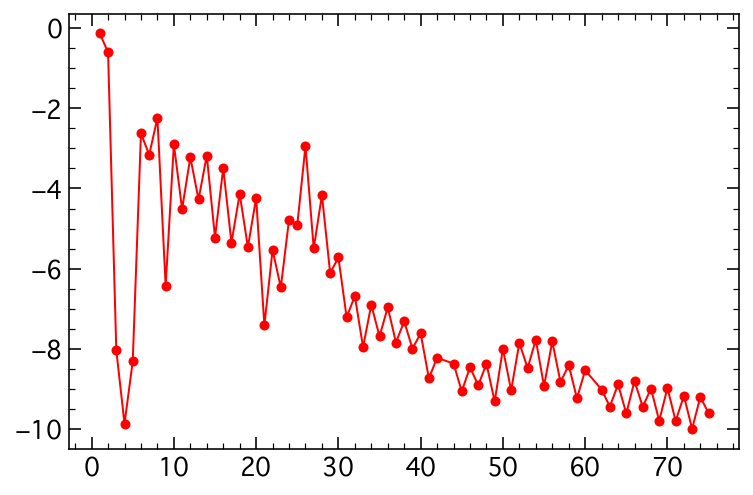

In [65]:
plt.plot(atoms['Z'],np.log10(eps/total_mass),'ro-',markersize=4,lw=1);

## Calculate X, Y, Z

In [66]:
X = eps[0]/total_mass
Y = eps[1]/total_mass

In [67]:
zzz = (atoms['Z'] > 2)
Z = eps[zzz].sum()/total_mass

In [68]:
print("\nMean abundances by mass: X=H, Y=He, Z=metals; mean mass per H atom, µ.\n")
print("\tX = {0:0.4f}".format(X))
print("\tY = {0:0.4f}".format(Y))
print("\tZ = {0:0.4f}".format(Z))
print("\tµ = {0:0.4f}".format(1./X))


Mean abundances by mass: X=H, Y=He, Z=metals; mean mass per H atom, µ.

	X = 0.7376
	Y = 0.2493
	Z = 0.0131
	µ = 1.3558


Thus the metal mass fraction in the solar system is **Z = 0.0131**.

The mean mass per H is **µ = 1.36.**